<a href="https://colab.research.google.com/github/LordLean/SemEval-2022-Task-4/blob/main/sem_eval_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main imports and code

In [184]:
from IPython.display import clear_output

In [185]:
# check which gpu we're using
!nvidia-smi

Wed Feb 23 15:28:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    31W /  70W |   4440MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [186]:
!pip install simpletransformers
!pip install tensorboardx

clear_output()

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval

In [ ]:
!pip install texthero
!pip install -U textblob
!python -m textblob.download_corpora

clear_output()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob,Word

In [ ]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Cuda available?  True


In [ ]:
if cuda_available:
  import tensorflow as tf
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


# Fetch Don't Patronize Me! data manager module

In [ ]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [ ]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [ ]:
!wget https://raw.githubusercontent.com/LordLean/SemEval-2022-Task-4/main/dontpatronizeme_v1.4/dontpatronizeme_pcl.tsv

!wget https://raw.githubusercontent.com/LordLean/SemEval-2022-Task-4/main/dontpatronizeme_v1.4/dontpatronizeme_categories.tsv

--2022-02-23 13:32:20--  https://raw.githubusercontent.com/LordLean/SemEval-2022-Task-4/main/dontpatronizeme_v1.4/dontpatronizeme_pcl.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3122842 (3.0M) [text/plain]
Saving to: ‘dontpatronizeme_pcl.tsv’

dontpatronizeme_pcl 100%[===================>]   2.98M  --.-KB/s    in 0.03s   

2022-02-23 13:32:23 (107 MB/s) - ‘dontpatronizeme_pcl.tsv’ saved [3122842/3122842]

--2022-02-23 13:32:23--  https://raw.githubusercontent.com/LordLean/SemEval-2022-Task-4/main/dontpatronizeme_v1.4/dontpatronizeme_categories.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|

In [ ]:
from dont_patronize_me import DontPatronizeMe

In [ ]:
dpm = DontPatronizeMe('.', '.')

In [ ]:
dpm.load_task1()

# Load paragraph IDs

In [ ]:
!wget https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv
!wget https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv

--2022-02-23 13:32:23--  https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61151 (60K) [text/plain]
Saving to: ‘dev_semeval_parids-labels.csv’

dev_semeval_parids- 100%[===================>]  59.72K  --.-KB/s    in 0.004s  

2022-02-23 13:32:23 (15.8 MB/s) - ‘dev_semeval_parids-labels.csv’ saved [61151/61151]

--2022-02-23 13:32:23--  https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com

In [ ]:
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')

In [ ]:
trids.head()

,par_id,label
0,4341,"[1, 0, 0, 1, 0, 0, 0]"
1,4136,"[0, 1, 0, 0, 0, 0, 0]"
2,10352,"[1, 0, 0, 0, 0, 1, 0]"
3,8279,"[0, 0, 0, 1, 0, 0, 0]"
4,1164,"[1, 0, 0, 1, 1, 1, 0]"


In [ ]:
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)



# Rebuild training set (Task 1)

In [ ]:
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  

In [ ]:
trdf1 = pd.DataFrame(rows)

## Training set EDA

In [ ]:
trdf1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8375 entries, 0 to 8374
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   par_id  8375 non-null   object
 1   text    8375 non-null   object
 2   label   8375 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 196.4+ KB


In [ ]:
trdf1.isnull().sum()

par_id    0
text      0
label     0
dtype: int64

In [ ]:
trdf1.head()

,par_id,text,label
0,4341,"The scheme saw an estimated 150,000 children f...",1
1,4136,Durban 's homeless communities reconciliation ...,1
2,10352,The next immediate problem that cropped up was...,1
3,8279,Far more important than the implications for t...,1
4,1164,To strengthen child-sensitive social protectio...,1


In [ ]:
trdf1.label.value_counts()

0    7581
1     794
Name: label, dtype: int64

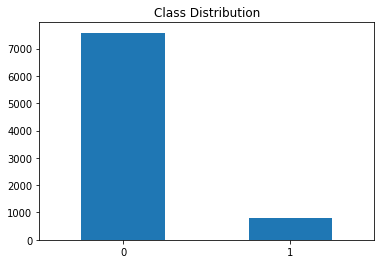

In [ ]:
trdf1.label.value_counts().plot.bar(rot=0, title="Class Distribution")

In [ ]:
full_text =" ".join([sent for sent in trdf1["text"]])

In [ ]:
len(full_text.split(" "))

407655

In [ ]:
df = trdf1.copy()

In [ ]:
import re
import string

# remove digits
df["clean"] = df["text"].apply(lambda x : re.sub('\w*\d\w*','', x))

# remove uppercase
df["clean"] = df["clean"].apply(lambda x : x.lower())

# remove punc
df["clean"] = df["clean"].apply(lambda x : re.sub('[%s]' % re.escape(string.punctuation), '', x))

# remove excess whitespace
df['clean']=df['clean'].apply(lambda x: re.sub(' +',' ',x))

In [ ]:
# visualize clean changes
for i in range(3):
  print()
  for sent in ["text", "clean"]:
    print(sent)
    print(df[sent][i])


text
The scheme saw an estimated 150,000 children from poor families being sent to parts of the British Empire between 1920 and 1974 , by religious orders and charities who said they would lead better lives .
clean
the scheme saw an estimated children from poor families being sent to parts of the british empire between and by religious orders and charities who said they would lead better lives 

text
Durban 's homeless communities reconciliation lunch
clean
durban s homeless communities reconciliation lunch

text
The next immediate problem that cropped up was how to assist the unfortunate couple , as neither of them possessed a birth certificate , a marriage certificate , or even an identity card . The Samurdhi Officer Dhanapala lamented explaining how agonizing it was for him to bear , when he came across the majority of poor families in the village did not possess even an ID to assist them officially .
clean
the next immediate problem that cropped up was how to assist the unfortunat

In [ ]:
# length of each sentence in characters
df["char_length"] = df["clean"].apply(lambda x: len(x))
# length of each sentence in tokens
df["token_length"] = df["clean"].apply(lambda x: len(x.split(" "))) 

In [ ]:
# sentiment - polarity
df["sentiment_polarity"] = df["clean"].apply(lambda x : TextBlob(x).sentiment.polarity)
# sentiment - subjectivity
df["sentiment_subjectivity"] = df["clean"].apply(lambda x : TextBlob(x).sentiment.subjectivity)

In [ ]:
df.head(3)

,par_id,text,label,clean,char_length,token_length,sentiment_polarity,sentiment_subjectivity
0,4341,"The scheme saw an estimated 150,000 children f...",1,the scheme saw an estimated children from poor...,182,32,0.025,0.337500
1,4136,Durban 's homeless communities reconciliation ...,1,durban s homeless communities reconciliation l...,50,6,0.000,0.000000
2,10352,The next immediate problem that cropped up was...,1,the next immediate problem that cropped up was...,387,67,-0.300,0.533333


In [ ]:
df.describe()

,label,char_length,token_length,sentiment_polarity,sentiment_subjectivity
count,8375.000000,8375.000000,8375.000000,8375.000000,8375.000000
mean,0.094806,254.703403,43.998328,0.022809,0.389246
std,0.292964,155.299001,26.287619,0.200545,0.211969
min,0.000000,8.000000,1.000000,-1.000000,0.000000
25%,0.000000,160.000000,28.000000,-0.075000,0.266667
50%,0.000000,222.000000,38.000000,0.000000,0.400000
75%,0.000000,315.000000,54.000000,0.129167,0.510417
max,1.000000,5307.000000,819.000000,1.000000,1.000000


In [ ]:
corr = df.corr(method="pearson")
corr.style.background_gradient(cmap="coolwarm")

,label,char_length,token_length,sentiment_polarity,sentiment_subjectivity
label,1.000000,0.039477,0.056494,0.027890,0.046320
char_length,0.039477,1.000000,0.987039,0.093197,0.134485
token_length,0.056494,0.987039,1.000000,0.104630,0.147567
sentiment_polarity,0.027890,0.093197,0.104630,1.000000,0.105758
sentiment_subjectivity,0.046320,0.134485,0.147567,0.105758,1.000000


## Synonyms

In [ ]:
import nltk
from nltk.corpus import wordnet as wn

nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [ ]:
def get_synonyms(token):
  syns = [ss.lemma_names() for ss in wn.synsets(token)]
  syns = list(set([word for sublist in syns for word in sublist]))
  return syns

In [ ]:
get_synonyms("dog")

['heel',
 'click',
 'bounder',
 'blackguard',
 'hot_dog',
 'wienerwurst',
 'go_after',
 'track',
 'chase',
 'detent',
 'chase_after',
 'trail',
 'firedog',
 'hound',
 'dog-iron',
 'cad',
 'frank',
 'Canis_familiaris',
 'frankfurter',
 'andiron',
 'give_chase',
 'frump',
 'domestic_dog',
 'tag',
 'hotdog',
 'pawl',
 'weenie',
 'dog',
 'tail',
 'wiener']

# Rebuild test set (Task 1)

In [ ]:
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  

In [ ]:
len(rows)

2094

In [ ]:
tedf1 = pd.DataFrame(rows)

# RoBERTa Baseline for Task 1

In [ ]:
# downsample negative instances
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)

training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])

In [193]:
training_set1

,par_id,text,label
0,4341,"The scheme saw an estimated 150,000 children f...",1
1,4136,Durban 's homeless communities reconciliation ...,1
2,10352,The next immediate problem that cropped up was...,1
3,8279,Far more important than the implications for t...,1
4,1164,To strengthen child-sensitive social protectio...,1
...,...,...,...
2377,1775,Last but not the least element of culpability ...,0
2378,1776,"Then , taking the art of counter-intuitive non...",0
2379,1777,Kagunga village was reported to lack necessary...,0
2380,1778,"""After her parents high-profile divorce after ...",0


In [194]:
model_args = ClassificationArgs(num_train_epochs=5,
                                      # learning_rate = 1e-4,
                                      no_save=True, 
                                      no_cache=True, 
                                      overwrite_output_dir=True)
model = ClassificationModel("roberta", 
                                  'roberta-base', 
                                  args = model_args, 
                                  num_labels=2, 
                                  use_cuda=cuda_available)
# train model
model.train_model(training_set1[['text', 'label']])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

  0%|          | 0/2382 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.


(1490, 0.28301861855543636)

In [198]:
# run predictions on dev set
preds, _ = model.predict(tedf1.text.tolist())

y_true = tedf1.label.to_list()

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

In [199]:
from sklearn.metrics import classification_report

print(classification_report(y_true, preds))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92      1895
           1       0.38      0.74      0.51       199

    accuracy                           0.86      2094
   macro avg       0.68      0.81      0.71      2094
weighted avg       0.91      0.86      0.88      2094



### Predict on Test Dataset

#### Load Test

In [ ]:
!wget https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/TEST/task4_test.tsv

--2022-02-23 14:25:36--  https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/TEST/task4_test.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1145277 (1.1M) [text/plain]
Saving to: ‘task4_test.tsv’

task4_test.tsv      100%[===================>]   1.09M  --.-KB/s    in 0.02s   

2022-02-23 14:25:36 (45.0 MB/s) - ‘task4_test.tsv’ saved [1145277/1145277]



In [187]:
import os

def load_test_df():
		"""
		Return test dataframe in correct format.
		"""
		rows=[]
		with open(os.path.join('.', 'task4_test.tsv')) as f:
			for line in f.readlines():
				par_id=line.strip().split('\t')[0]
				art_id = line.strip().split('\t')[1]
				keyword=line.strip().split('\t')[2]
				country=line.strip().split('\t')[3]
				t=line.strip().split('\t')[4]#.lower()
				l=line.strip().split('\t')[-1]
				if l=='0' or l=='1':
					lbin=0
				else:
					lbin=1
				rows.append(
					{'par_id':par_id,
					'art_id':art_id,
					'keyword':keyword,
					'country':country,
					'text':t, 
					'label':lbin, 
					'orig_label':l
					}
					)
		df=pd.DataFrame(rows, columns=['par_id', 'art_id', 'keyword', 'country', 'text', 'label', 'orig_label']) 
		return df

In [188]:
test_df = load_test_df()

#### Predict

In [195]:
test_preds, _ = model.predict(test_df.text.tolist())

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/3832 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

In [196]:
with open("task1.txt", "w") as outfile:
  for pi in test_preds:
    str_pi = str(pi)
    outfile.write("{}\n".format(str_pi + " "))

In [202]:
!zip -r "task1.zip" "task1.txt"

  adding: task1.txt (deflated 94%)


In [203]:
!ls

 dev_semeval_parids-labels.csv	  runs
 dontpatronizeme_categories.tsv   sample_data
 dontpatronizeme_pcl.tsv	 'task1 (1).txt'
 dont_patronize_me.py		  task1.csv
 listfile.txt			  task1.txt
 outputs			  task1.zip
 __pycache__			  task4_test.tsv
 ref				  train_semeval_parids-labels.csv
 res


In [204]:
from google.colab import files

files.download("task1.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>